# 프로젝트 : CIFAR-10 이미지 생성하기

* FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용
* CIFAR-10 데이터를 생성하는 모델
* -------------------------
* 이미지 데이터의 shape가 (28, 28, 1) ->  (32, 32, 3)으로 변경
* 생성자, 판별자 모델의 입출력 shape 및 모델 구조 변경
* 이미지가 단색의 grayscale -> RGB 3채널의 컬러이미지로 변경
* 시각화 과정에서 고려할 점이 있습니다
* 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다


In [3]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.6.0
2.9.0


## STEP 1. 작업환경 구성하기

In [4]:
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

In [5]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


## STEP 2. 데이터셋 구성하기

In [6]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

* 학습에 사용할 train_x의 이미지를 -1, 1로 정규화

In [7]:
#학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
train_x = (train_x.astype('float32') - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


* 로드한 학습 데이터를 시각화를 통해 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


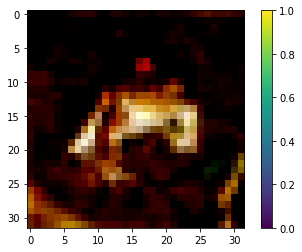

In [8]:
# 첫 번째 이미지 선택
plt.imshow(train_x[0])
plt.colorbar()  #각 픽셀의 값과 그에 따른 색도 확인
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

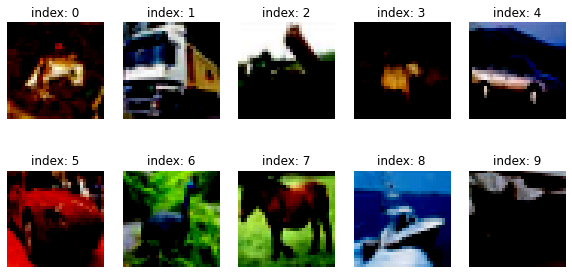

In [9]:
# 로드한 학습 데이터를 시각화를 통해 확인
plt.figure(figsize=(10, 5))  #이미지의 전체 프레임의 크기

#열 개 정도를 한 번에 띄워보는문장
for i in range(10):
    plt.subplot(2, 5, i+1)  #여러 개의 이미지를 한 번에 띄우고 싶을 때(plt.subplot(row, col, index))
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')  #이미지에 제목으로 라벨값 표시
    plt.axis('off')  #불필요한 축 제거
plt.show()

In [10]:
#import cv2                  # OpenCV 라이브러리로 이미지를 처리하기 위해 필요

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

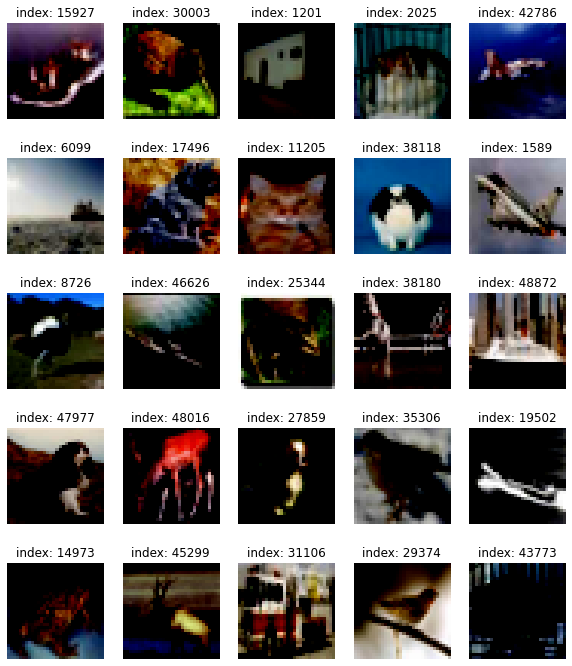

In [11]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000) #훈련세트 5만개
    plt.imshow(train_x[random_index])
    #plt.imshow(cv2.cvtColor(train_x[random_index], cv2.COLOR_BGR2RGB))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

* CIFAR-10 데이터 세트
  - CIFAR-10 데이터 세트는 10개 클래스에 32x32 컬러 이미지 60000개로 구성되어 있으며, 
  - 클래스당 6000개 이미지가 있습니다. 
  - 50000개의 훈련 이미지와 10000개의 테스트 이미지가 있습니다.

  - 데이터 세트는 5개의 훈련 배치와 
    1개의 테스트 배치로 나뉘며, 
    각각 10000개의 이미지가 있습니다. 
  - 테스트 배치에는 각 클래스에서 무작위로 선택된 이미지가 정확히 1000개 있습니다. 
  - 훈련 배치에는 나머지 이미지가 무작위 순서로 포함되지만, 
    일부 훈련 배치에는 한 클래스의 이미지가 다른 클래스보다 더 많이 포함될 수 있습니다. 
    훈련 배치에는 각 클래스에서 정확히 5000개의 이미지가 포함됩니다.

  - 데이터 세트의 클래스와 각 클래스에서 무작위로 선택된 이미지 10개가 있습니다.

* tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성

In [12]:
print(len(train_x)), print(len(test_x))

50000
10000


(None, None)

In [13]:
BUFFER_SIZE = 50000  #전체 데이터를 섞기 위해 50,000으로 설정
BATCH_SIZE = 256

In [14]:
# from_tensor_slices : 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다
# train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 한다.

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) #데이터셋을 섞는다 

## STEP 3. 생성자 모델 구현하기

#### (1) 생성자 구현하기 
* (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성

In [15]:
def make_generator_model():
    #시작
    model = tf.keras.Sequential()
    
    #첫번째 밀도있는 레이어
    #units은 8*8*256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    #배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    #두번째 - 레이어 모양변경
    model.add(layers.Reshape((8, 8, 256)))
    
    #모델 레이어 (8,8,256) 추가
    assert model.output_shape == (None, 8, 8, 256) # 주목: 배치사이즈로 None이 주어집니다.
    
    #세번째: Conv2DTranspose 레이어
    #커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    #배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    #네번째 : Conv2DTranspose 레이어
    #커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    #배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    #다섯번째 : Conv2DTranspose 레이어
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

* Conv2DTranspose 레이어가 중요
* 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층
* 세 번의 Conv2DTranspose 층을 이용해 (8, 8, 256) → (16, 16, 64) → (32, 32, 3) 순으로 이미지를 키워나갑니다
* 최종 사이즈인 (32, 32, 3)은 우리가 준비했던 데이터셋과 형상이 동일
* BatchNormalization 레이어 : 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화
* 활성화 함수는 모두 LeakyReLU를 사용
* 마지막 층에는 활성화 함수로 tanh를 사용 : -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함

In [16]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

* noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해보기

In [17]:
noise = tf.random.normal([1, 100]) #가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 생성

In [18]:
# 지금은 학습하는 중이 아니니 training=False를 설정해 주어야 한다.
# Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 
# training=False을 주어야 올바른 결과를 얻을 수 있습니다

generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

* [1, 32, 32, 3] 사이즈의 이미지
* 1개(batch_size=1),  (32, 32, 3) 사이즈 이미지

* matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 
* 0번째와 3번째 축의 인덱스를 0으로 설정해서 (32, 32) shape의 이미지를 꺼낼 수 있도록 해야 합니다

* 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

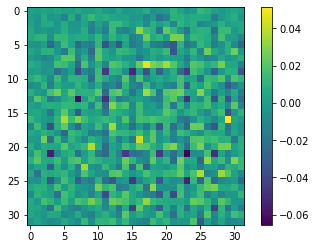

In [19]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## STEP 4. 판별자 모델 구현하기

* (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성
* 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인

#### 판별자 구현하기

In [20]:
# 판별자 구현
def make_discriminator_model():
    #시작
    model = tf.keras.Sequential()
    
    #첫번째 Conv2D 레이어 
    #필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 칼라사진
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    #LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    #Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    #두번째 Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    #LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    #Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    #세번째 Flatten Layer
    model.add(layers.Flatten())
    #네번째 Dense Layer
    model.add(layers.Dense(1))

    return model

* 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나갑니다.
* 첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는 
* 다음 층을 거치며 (32, 32, 3) → (16, 16, 64) → (8, 8, 128)까지 줄어들게 됩니다
* Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 8x8x128=8192, 즉 (1, 8192) 형상의 벡터로 변환
* 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력

In [21]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [22]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00140681]], dtype=float32)>

## STEP 5. 손실함수와 최적화 함수 구현하기

* 생성자와 판별자의 손실함수(loss)를 구현
* 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현
* 생성자와 판별자를 최적화하는 optimizer를 정의

In [35]:
# 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한다
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### 생성자 손실함수(loss)를 구현

In [36]:
# generator_loss : fake_output가 1에 가까워지기를 바라므로 tf.ones_like와의 교차 엔트로피값을 계산

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### 판별자 손실함수(loss)를 구현

In [37]:
# discriminator_loss

def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

* discriminator accuracy
* real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적

#### 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수

In [38]:
#판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

#### 최적화 함수(optimizer)

In [39]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [40]:
# 학습이 어떻게 진행되어가고 있는지를 확인

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 6. 훈련과정 상세 기능 구현하기

* 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현
* 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현
* 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는
  draw_train_history() 함수를 구현
* training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정

#### 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수 구현

In [41]:
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images): #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: #(3) tf.GradientTape() 오픈
      generated_images = generator(noise, training=True)  #(4) generated_images 생성

      #(5) discriminator 판별
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      #(6) loss 계산
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
      #(7) accuracy 계산
      real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)     

    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

#### 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현

In [42]:
# train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

#### draw_train_history() 함수
* 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화

In [43]:
#훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 
#그래프로 시각화하는 draw_train_history() 함수를 구현

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

#### training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정

In [44]:
# checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 7. 학습 과정 진행하기

* 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행
* 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현
* 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출

In [45]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                # GIF를 위한 이미지를 바로 생성합니다.
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                
                # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        # 5 에포크가 지날 때마다 모델을 저장합니다.        
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # 마지막 에포크가 끝난 후 생성합니다.
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [46]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

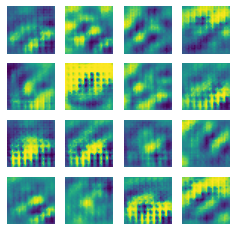

Epoch 13 | iter 1
Time for epoch 13 : 1 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

#### 학습과정 시각화하기

In [87]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif'

#파일을 열기
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        
        # 이미지를 하나씩 붙여나가는 방식
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif

-rw-r--r-- 1 root root 1313650 Dec  1 18:40 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif


## STEP 8. (optional) GAN 훈련 과정 개선하기

* STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석
* 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출

#### => (case 1)

In [126]:
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples_new
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints_new
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history_new

#### 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images_new() 함수를 구현

In [127]:
# train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수

def generate_and_save_images_new(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples_new/sample_epoch_new_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

#### draw_train_history_new() 함수
* 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화

In [128]:
#훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 
#그래프로 시각화하는 draw_train_history() 함수를 구현

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history_new(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history_new/train_history_new_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [129]:
# checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_new'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### 학습 과정 진행하기

In [130]:
def train_new(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                # GIF를 위한 이미지를 바로 생성합니다.
                display.clear_output(wait=True)
                generate_and_save_images_new(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                
                # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        # 5 에포크가 지날 때마다 모델을 저장합니다.        
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # 마지막 에포크가 끝난 후 생성합니다.
        display.clear_output(wait=True)
        generate_and_save_images_new(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history_new(history, epoch)

In [131]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

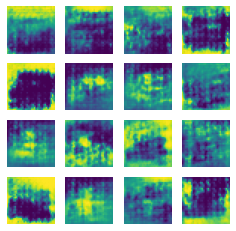

Time for training : 1533 sec


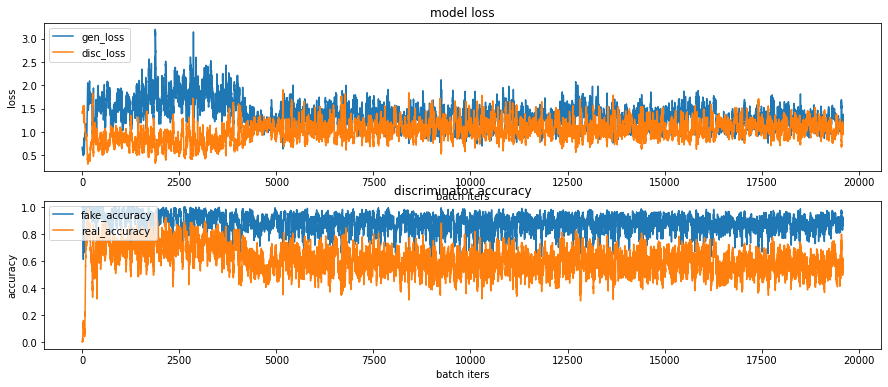

CPU times: user 26min 11s, sys: 2min 19s, total: 28min 31s
Wall time: 25min 34s


In [132]:
%%time
train_new(train_dataset, EPOCHS, save_every)

In [133]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan_new.gif'

#파일을 열기
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples_new/sample_epoch_new_*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        
        # 이미지를 하나씩 붙여나가는 방식
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan_new.gif

-rw-r--r-- 1 root root 1873513 Dec  1 20:15 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan_new.gif


* ------------- 추가로 작업한 부분 end

#### => case2 - checkpoint 모듈을 활용하여 모델을 재로드

In [19]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[1])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

NameError: name 'checkpoint' is not defined

In [90]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

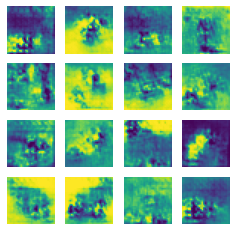

Time for training : 1522 sec


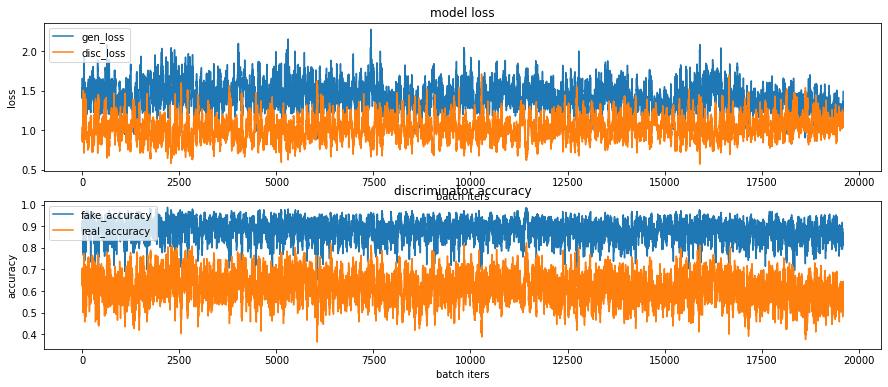

CPU times: user 26min 14s, sys: 2min 23s, total: 28min 37s
Wall time: 25min 23s


In [91]:
%%time
train(train_dataset, EPOCHS, save_every)

#### 학습과정 시각화하기

In [92]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan_1.gif'

#파일을 열기
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        
        # 이미지를 하나씩 붙여나가는 방식
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan_1.gif

-rw-r--r-- 1 root root 1842877 Dec  1 19:42 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan_1.gif


# 회고

(노은하)
* 흑백이미지에 비해 칼라이미지의 경우 더 식별이 안되는것으로 확인되었다.이유는 알수 없다
* 